In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from parsers.parse_data_dictionary import parse_data_dictionary
from parsers.parse_puf_files import parse_puf_files, custom_puf_handling
from util.plot import plot_config

# Add dependencies - running the model
import shap

import pickle

plot_config(theme="derisc")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Using theme: derisc


In [3]:
# Read data dictionary
data_folder = os.path.join("data")
data_dict_path = os.path.join(data_folder, "Data_Dictionary.xlsx")
data_dict = parse_data_dictionary(data_dict_path, drop_bad=True).set_index('Variable')

# Print available factors
print(f"Potentially relevant factors for processing: {data_dict.index.values}")

# Preview
data_dict.head(5)

Potentially relevant factors for processing: ['TBIRTH_YEAR' 'RHISPANIC' 'RRACE' 'EEDUC' 'MS' 'GENID_DESCRIBE'
 'THHLD_NUMPER' 'THHLD_NUMKID' 'THHLD_NUMADLT' 'KIDS_LT5Y' 'KIDS_5_11Y'
 'KIDS_12_17Y' 'TENROLLPUB' 'TENROLLPRV' 'TENROLLHMSCH' 'ANYWORK'
 'KINDWORK' 'SETTING' 'TWDAYS' 'FRMLA_YN' 'ND_DISPLACE' 'ND_TYPE1'
 'ND_TYPE2' 'ND_TYPE3' 'ND_TYPE4' 'ND_TYPE5' 'ND_HOWLONG' 'ND_DAMAGE'
 'ND_FDSHRTAGE' 'ND_WATER' 'ND_ELCTRC' 'ND_UNSANITARY' 'ANXIOUS' 'WORRY'
 'INTEREST' 'DOWN' 'SEEING' 'HEARING' 'REMEMBERING' 'MOBILITY' 'SELFCARE'
 'UNDERSTAND' 'TENURE' 'TRENTAMT' 'LIVQTRRV' 'INCOME' 'EST_ST' 'EST_MSA'
 'HWEIGHT' 'REGION']


,Type,Name,Values,Conversion
Variable,,,,
TBIRTH_YEAR,Discrete,Birth year,1934 to 2004,{'1934 to 2004': '1934 to 2004'}
RHISPANIC,Nominal,Hispanic origin,1) No\n2) Yes,"{1: 'No', 2: 'Yes'}"
RRACE,Nominal,Race,1) White\n2) Black\n3) Asian\n4) Other/Mixed,"{1: 'White', 2: 'Black', 3: 'Asian', 4: 'Other..."
EEDUC,Ordinal,Educational attainment,1) Less than high school\n2) Some high school\...,"{1: 'Less than high school', 2: 'Some high sch..."
MS,Nominal,Marital status,1) Now married\n2) Widowed\n3) Divorced\n4) Se...,"{1: 'Now married', 2: 'Widowed', 3: 'Divorced'..."


In [4]:
# Locate folder where data is stored
puf_folder = PUF_FOLDER # Save the zipped PUF files from the HPS in a known location and reference the path here
assert os.path.exists(puf_folder), f"Could not locate {puf_folder}"

# Locate folder to write any outputs
img_folder = os.path.join("img")

# Read PUF files
puf = parse_puf_files(puf_folder)

# Preview
print(f"Found {puf.shape[0]:,.0f} records")
puf.head(5)

Setting bad_vals ([-88, -99]) = NaN
Found 1,326,503 records


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,ND_MED,HLTH_MHCHLD1,HLTH_MHCHLD2,HLTH_MHCHLD3,HLTH_MHCHLD4,HLTH_MHCHLD5,HLTH_MHCHLD6,HLTH_MHCHLD7,HLTH_MHCHLD8,HLTH_MHCHLD9
0,V520000001,52.0,44,NaN,1,297.631871,1123.798115,1968,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V520000002,52.0,5,NaN,2,544.644346,1009.342253,1959,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V520000003,52.0,48,NaN,2,187.423803,346.468149,1946,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V520000004,52.0,11,47900.0,2,116.768607,199.033089,1984,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V520000005,52.0,28,NaN,2,700.047941,1329.911657,1963,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Read in area data
area_path = os.path.join(data_folder, "Area_Attributes.xlsx")
msa_field, state_field = "EST_MSA", "EST_ST"
area_cats = [msa_field, state_field]
areas = dict.fromkeys(area_cats)
for area_cat in area_cats:
    areas[area_cat] = pd.read_excel(area_path, sheet_name=area_cat).set_index(area_cat)

# Read and append area dictionary
dict_sheet = "Data Dictionary"
area_dict = pd.read_excel(area_path, sheet_name=dict_sheet).set_index('Variable')
data_dict = pd.concat([data_dict, area_dict], axis=0)

# Determine columns to be added
all_cols = list(map(lambda x: list(x.columns), [areas[area_cat] for area_cat in area_cats]))
area_cols  = list(set.union(*map(set, all_cols)))
print(f"Will add area attributes: {area_cols}")

# Get unique values
msas = puf[msa_field].dropna().unique()
states = puf[state_field].dropna().unique()

# Append area attributes
puf[area_cols] = ''
for col in area_cols:
    if col in areas[state_field].columns:
        for state in states:
            idx = puf[state_field] == state
            puf.loc[idx, col] = areas[state_field].loc[state, col]
    if col in areas[msa_field].columns:
        for msa in msas:
            jdx = puf[msa_field] == msa
            puf.loc[jdx, col] = areas[msa_field].loc[msa, col]

# Preview
puf.head(5)

Will add area attributes: ['DISASTERS_2021-2023', 'VACANCY_HOMEOWNER_2022', 'SATISFACTION_HOME_2021', 'SATISFACTION_NGBD_2021', 'UNEMPLOYMENT_2022', 'VACANCY_RENTAL_2022', 'RATE_HOMEOWNER_2022', 'METRO_AREA', 'STATE', 'POPULATION_TREND_10YR', 'POPULATION_2020']


Unknown extension is not supported and will be removed
Conditional Formatting extension is not supported and will be removed
Unknown extension is not supported and will be removed
Conditional Formatting extension is not supported and will be removed


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,VACANCY_HOMEOWNER_2022,SATISFACTION_HOME_2021,SATISFACTION_NGBD_2021,UNEMPLOYMENT_2022,VACANCY_RENTAL_2022,RATE_HOMEOWNER_2022,METRO_AREA,STATE,POPULATION_TREND_10YR,POPULATION_2020
0,V520000001,52.0,44,NaN,1,297.631871,1123.798115,1968,2,1,...,0.6,NaN,NaN,3.2,4.6,65.8,,Rhode Island,0.040216,1096345.0
1,V520000002,52.0,5,NaN,2,544.644346,1009.342253,1959,2,1,...,1.5,NaN,NaN,3.3,10.5,66.8,,Arkansas,0.031565,3014195.0
2,V520000003,52.0,48,NaN,2,187.423803,346.468149,1946,2,1,...,0.8,0.884599,NaN,3.9,7.9,63.6,,Texas,0.15809,29232474.0
3,V520000004,52.0,11,47900.0,2,116.768607,199.033089,1984,2,1,...,0.6,0.921331,0.928345,3.0,5.3,66.2,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",District of Columbia,0.121192,6366679
4,V520000005,52.0,28,NaN,2,700.047941,1329.911657,1963,2,1,...,0.6,NaN,NaN,3.9,8.4,73.1,,Mississippi,-0.004177,2958141.0


In [6]:
# Estimate percentage of households that were displaced
criteria = (puf.ND_DISPLACE == 1)
n_households = puf.HWEIGHT.sum()
n_displaced_households = puf[criteria].HWEIGHT.sum()
print(f"Estimated a displacement rate of {(n_displaced_households/n_households):.2%}")

Estimated a displacement rate of 1.12%


In [7]:
# Implement custom data handling
puf, data_dict = custom_puf_handling(puf, data_dict)

# Export processed data subset for dashboard
criteria = (puf.ND_DISPLACE == 1) 
# puf[criteria].to_csv("displaced_households.csv", index=False)

# Preview
puf[criteria].head(5)

Added new columns: ['HAZARD_TYPE', 'AGE_BIN', 'HH_BIN', 'RENT_BIN', 'INCOME_PER', 'DWELLTYPE', 'TENURE_STATUS', 'RMINORITY', 'SCHOOLENROLL', 'LIVQTR_OTHER', 'LIVQTR_MOBILE', 'LIVQTR_SINGLE', 'LIVQTR_MULTI', 'RETURNED', 'PROTRACTED', 'RECOVERY', 'PHASE', 'PHASE_RETURN', 'RETURN_1', 'RETURN_2', 'RETURN_3']


,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,...,LIVQTR_SINGLE,LIVQTR_MULTI,RETURNED,PROTRACTED,RECOVERY,PHASE,PHASE_RETURN,RETURN_1,RETURN_2,RETURN_3
7,V520000008,52.0,12,NaN,2,10141.479843,18633.438797,1994,2,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
70,V520000071,52.0,4,NaN,4,3504.757175,6529.976342,1950,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
108,V520000109,52.0,42,37980.0,1,801.677778,2856.430494,1972,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
110,V520000111,52.0,22,NaN,2,895.045567,1686.648972,1987,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
382,V520000383,52.0,42,NaN,1,4276.797681,7619.255295,1958,2,1,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Split data and apply weights

# Feature selection
dependent = "PHASE_RETURN" # options: RETURNED, PROTRACTED, RETURN_1, RETURN_2, RETURN_3, ND_HOWLONG, PHASE
independents = ['ND_DAMAGE',
                'ND_WATER', 'ND_ELCTRC', 'ND_UNSANITARY', 'ND_FDSHRTAGE', 
                'TENURE_STATUS', # 'TENURE',
                'HH_BIN', 'SCHOOLENROLL',
                'INCOME_PER', # 'INCOME',
                'RRACE',
                'DWELLTYPE', # 'LIVQTR_OTHER', 'LIVQTR_MOBILE, 'LIVQTR_SINGLE', 'LIVQTR_MULTI', # 'LIVQTRRV',
                'HAZARD_TYPE',
                'UNEMPLOYMENT_2022',
                'DISASTERS_2021-2023',
                # 'SATISFACTION_NGBD_2021',
                # 'SATISFACTION_HOME_2021',
                'RATE_HOMEOWNER_2022',
                'VACANCY_HOMEOWNER_2022', 'VACANCY_RENTAL_2022', 'POPULATION_TREND_10YR', # 'POPULATION_2020',
                'MS', 'RHISPANIC', # 'RMINORITY',
                'ANYWORK', 'AGE_BIN','EEDUC', 'MOBILITY', # 'RENT_BIN'
               ]
weights = "HWEIGHT"

# Choose class names
class_names = data_dict.loc[dependent, 'Conversion']

# Get data subset
data = puf[criteria].dropna(subset=[dependent]+independents).copy()
n_all, n_safe = puf[criteria].shape[0], data.shape[0]
print(f"Dropping {(n_all-n_safe):,.0f} rows with NaN values of {n_all:,.0f} records ({(n_safe/n_all):.1%} retained)")

# Arrange data
y = data[dependent] # Target variable
X = data[independents] # Features
w = data[weights].div(50).astype(int) # Weights
n_independents = len(independents)

Dropping 2,146 rows with NaN values of 11,715 records (81.7% retained)


In [9]:
# load the model from disk
filename = os.path.join("presaved", "model_forest.sav")
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model

Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


RandomForestClassifier(ccp_alpha=0.001, max_depth=5, min_samples_leaf=500,
                       n_estimators=300, random_state=99)

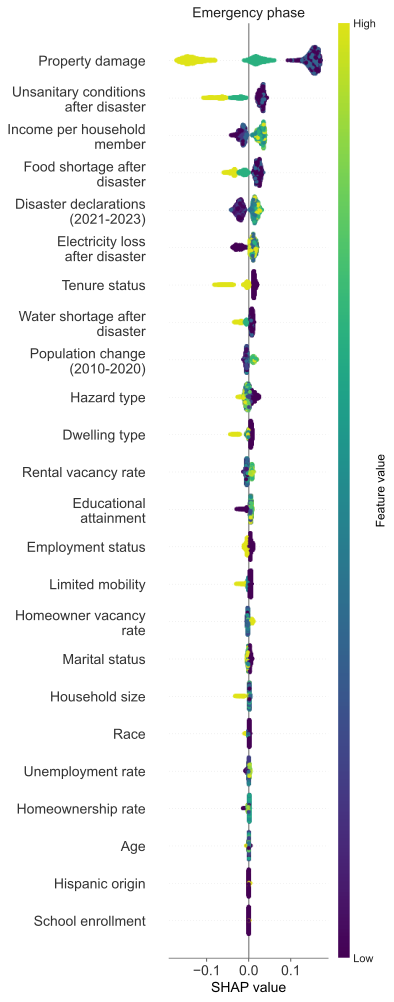

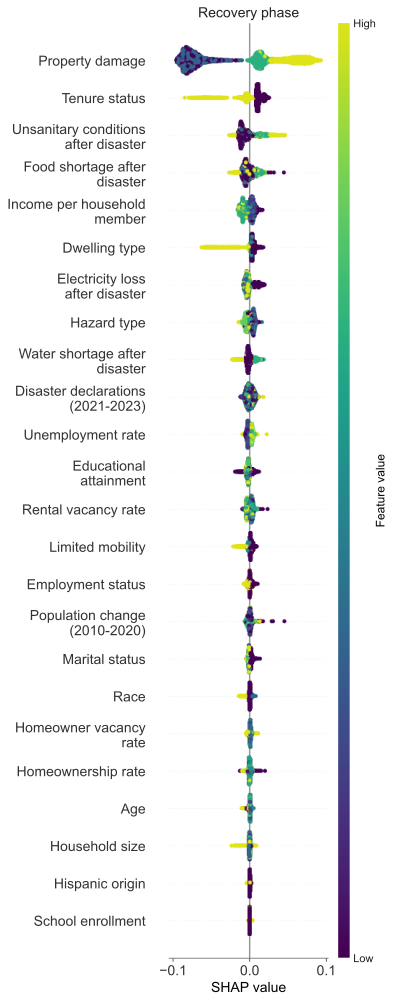

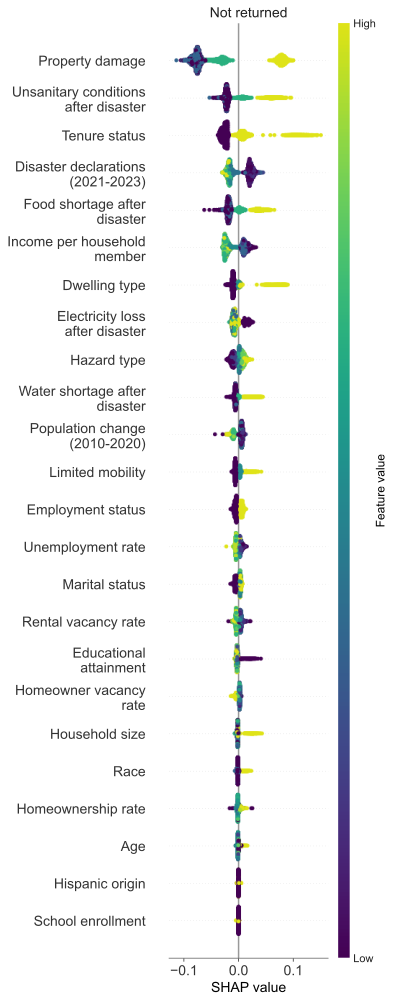

In [10]:
# TreeExplainer
explainer = shap.TreeExplainer(loaded_model)
rf_shap = explainer.shap_values(X) # NOTE: The first few cells need to be run to get X
# rf_shap_interaction = shap.TreeExplainer(best_rf).shap_interaction_values(X)

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('viridis')
new_cmap = truncate_colormap(cmap, 0, 0.95)

import textwrap

strs = data_dict.loc[X.columns, 'Name'].values
wrap_strs = [textwrap.fill(str, 21) for str in strs]

fs = 14
# Plot beeswarm
for i in range(3):
    class_name = class_names[i]
    fig = shap.summary_plot(rf_shap[i], X.values, feature_names=wrap_strs, plot_size=(5.5,14),
                      auto_size_plot=None, title=class_name, max_display=n_independents, show=False, cmap=new_cmap)
    ax = plt.gca()
    ax.set_title(class_name, fontsize=fs)
    ax.set(xlabel='SHAP value') 
    ax.tick_params(axis='both', which='major', labelsize=fs) 
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    plt.tight_layout()
    # plt.savefig(os.path.join(img_folder, f'Forest_SHAP_{class_name}'), dpi=200, facecolor='w')
    plt.show()

In [11]:
# fs = 14
# # Plot beeswarm
# for i in range(3):
#     class_name = class_names[i]
#     fig = shap.summary_plot(rf_shap[i], X.values, feature_names=wrap_strs, plot_size=(5.5,14), plot_type='bar',
#                       auto_size_plot=None, title=class_name, max_display=n_independents, show=False, cmap=plt.get_cmap('viridis'))
#     ax = plt.gca()
#     ax.set_title(class_name, fontsize=fs)
#     ax.set(xlabel='SHAP value') 
#     ax.tick_params(axis='both', which='major', labelsize=fs) 
#     ax.xaxis.label.set_size(fs)
#     ax.yaxis.label.set_size(fs)
#     plt.tight_layout()
#     # plt.savefig(os.path.join(img_folder, f'Forest_SHAP_{class_name}'), dpi=200, facecolor='w')
#     plt.show()

In [12]:
shap_values = explainer(X)
# phase_return = [
#     "Emergency phase" if shap_values[i, "PHASE_RETURN"].data == 0 else "Recovery phase" if shap_values[i, "PHASE_RETURN"].data == 1 else "Never returned" for i in range(shap_values.shape[0])
# ]


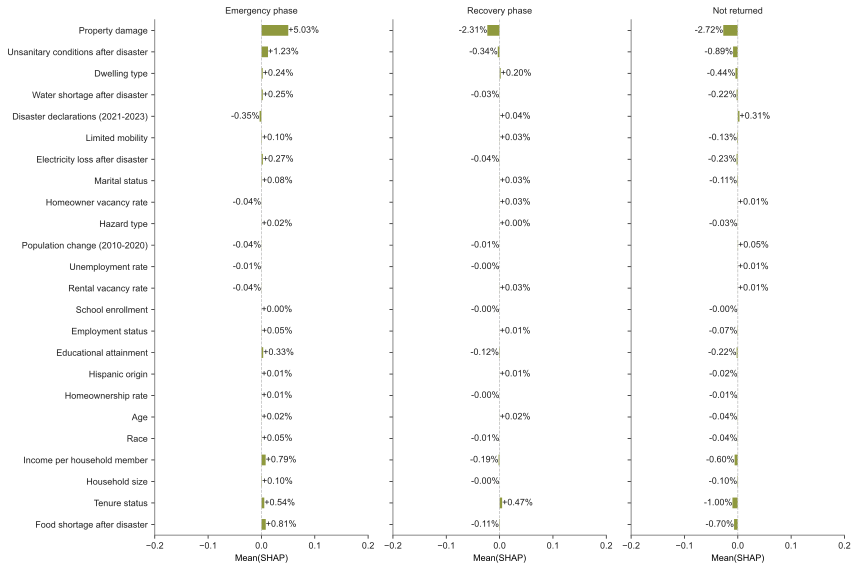

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12,8), sharey=True, sharex=True)
field = "Mean(SHAP)"

strs = data_dict.loc[X.columns, 'Name'].values
wrap_strs = [textwrap.fill(str, 21) for str in strs]

class_results = pd.DataFrame(index=data_dict.loc[X.columns, 'Name'], columns=class_names)
for i in class_names.keys():
    mean_shap = np.mean((rf_shap[i]), axis=0)
    class_results.loc[data_dict.loc[X.columns, 'Name'], class_names[i]] = mean_shap
class_results["order"] = class_results[class_names.values()].sum(axis=1)
class_results = class_results.sort_values(by="order", ascending=True)

for i, ax in zip(range(3), axs.flatten()):
    class_results[class_names[i]].plot.barh(ax=ax, legend=False)
    ax.bar_label(ax.containers[0], labels=[f"+{fi:.2%}" if fi >= 0 else f"{fi:.2%}" for fi in class_results[class_names[i]]])
    ax.axvline(0, linestyle='dashed', color='silver', linewidth=0.8)
    ax.set_title(class_names[i])
    ax.set_xlabel(field)
    ax.set_ylabel(None)
    ax.set_xlim(-0.2,0.2)
plt.tight_layout()
plt.show()

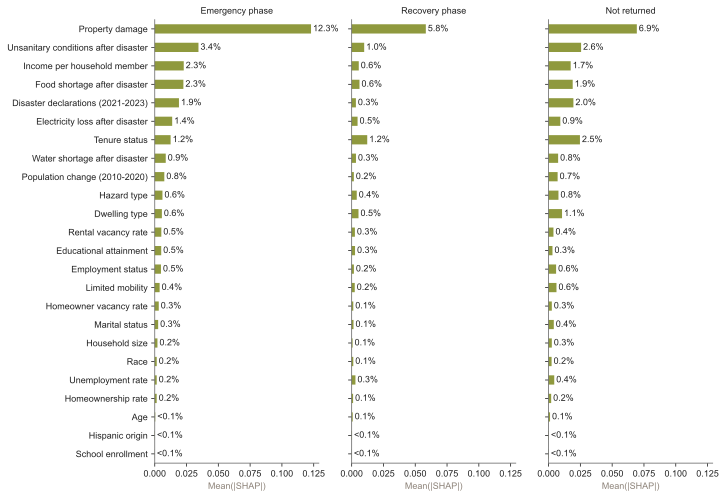

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(10,8), sharey=True, sharex=True)
field = "Mean(|SHAP|)"

class_results = pd.DataFrame(index=data_dict.loc[X.columns, 'Name'], columns=class_names)
for i in class_names.keys():
    mean_shap = np.mean(np.abs(rf_shap[i]), axis=0)
    class_results.loc[data_dict.loc[X.columns, 'Name'], class_names[i]] = mean_shap
class_results["order"] = class_results['Emergency phase'] #class_results[class_names.values()].sum(axis=1)
class_results = class_results.sort_values(by="order", ascending=True)

for i, ax in zip(range(3), axs.flatten()):
    class_results[class_names[i]].plot.barh(ax=ax, legend=False)
    ax.bar_label(ax.containers[0], padding=2, labels=[f"{fi:.1%}" if fi >=0.0005 else "<0.1%" for fi in class_results[class_names[i]]])
    ax.set_title(class_names[i], color="#212121")
    ax.set_xlabel(field, color="#8d8379")
    ax.set_ylabel(None)
    
plt.show()

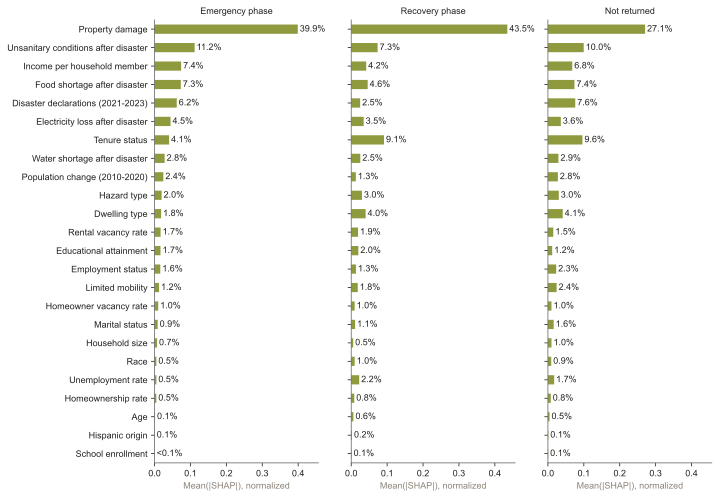

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(10,8), sharey=True, sharex=True)
field = "Mean(|SHAP|), normalized"

class_results = pd.DataFrame(index=data_dict.loc[X.columns, 'Name'], columns=class_names)
for i in class_names.keys():
    mean_shap = np.mean(np.abs(rf_shap[i]), axis=0)
    norm_shap = mean_shap/np.sum(mean_shap)
    class_results.loc[data_dict.loc[X.columns, 'Name'], class_names[i]] = norm_shap
class_results["order"] = class_results['Emergency phase'] #class_results[class_names.values()].sum(axis=1)
class_results = class_results.sort_values(by="order", ascending=True)

for i, ax in zip(range(3), axs.flatten()):
    class_results[class_names[i]].plot.barh(ax=ax, legend=False)
    ax.bar_label(ax.containers[0], padding=2, labels=[f"{fi:.1%}" if fi >=0.0005 else "<0.1%" for fi in class_results[class_names[i]]])
    ax.set_title(class_names[i], color="#212121")
    ax.set_xlabel(field, color="#8d8379")
    ax.set_ylabel(None)
    
plt.show()

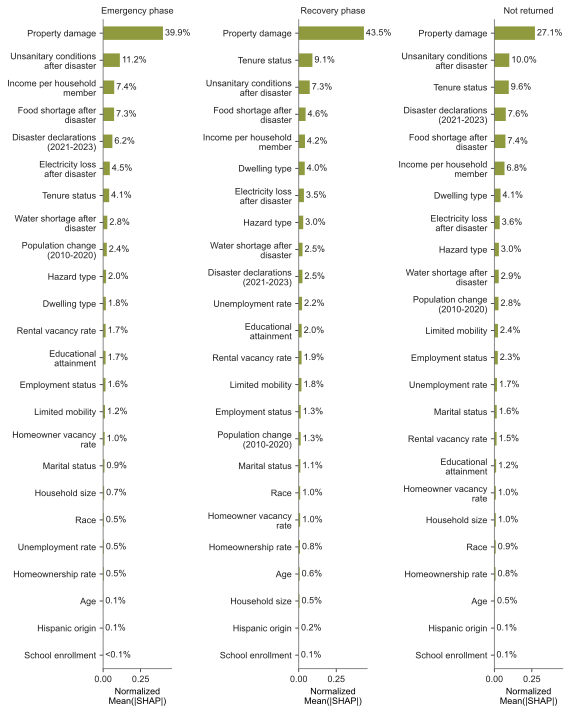

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(8,10), sharex=True)
field = "Normalized\nMean(|SHAP|)"

class_results = pd.DataFrame(index=data_dict.loc[X.columns, 'Name'], columns=class_names)
for i in class_names.keys():
    mean_shap = np.mean(np.abs(rf_shap[i]), axis=0)
    norm_shap = mean_shap/np.sum(mean_shap)
    class_results.loc[data_dict.loc[X.columns, 'Name'], class_names[i]] = norm_shap
class_results["order"] = class_results['Emergency phase'] #class_results[class_names.values()].sum(axis=1)
class_results = class_results.sort_values(by="order", ascending=True)

n = class_results.shape[0]
for i, ax in zip(range(3), axs.flatten()):
    temp = class_results[class_names[i]].sort_values(ascending=True)
    temp.index = [textwrap.fill(str, 21) for str in temp.index.values]
    temp.plot.barh(ax=ax, legend=False)
    ax.bar_label(ax.containers[0], padding=2, labels=[f"{fi:.1%}" if fi >=0.0005 else "<0.1%" for fi in temp])
    ax.set_title(class_names[i], color="#212121")
    ax.set_xlabel(field)
    ax.set_ylabel(None)
plt.tight_layout() 
plt.savefig(os.path.join(img_folder, f'Forest_SHAP_Agg'), dpi=200, facecolor='w')
plt.show()

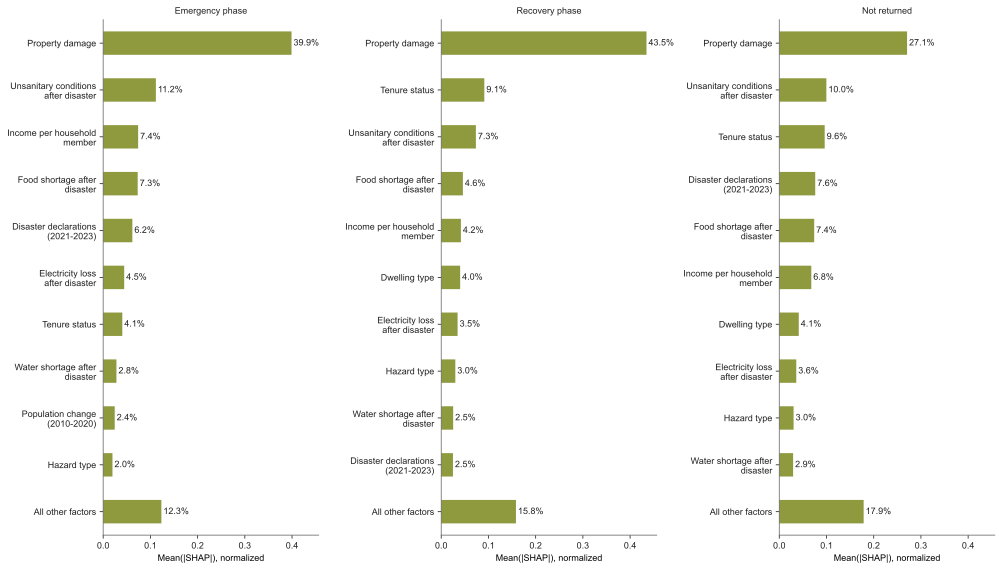

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(14,8), sharex=True)
field = "Mean(|SHAP|), normalized"

class_results = pd.DataFrame(index=data_dict.loc[X.columns, 'Name'], columns=class_names)
for i in class_names.keys():
    mean_shap = np.mean(np.abs(rf_shap[i]), axis=0)
    norm_shap = mean_shap/np.sum(mean_shap)
    class_results.loc[data_dict.loc[X.columns, 'Name'], class_names[i]] = norm_shap
class_results["order"] = class_results['Emergency phase'] #class_results[class_names.values()].sum(axis=1)
class_results = class_results.sort_values(by="order", ascending=True)

N = 10
n = class_results.shape[0]
for i, ax in zip(range(3), axs.flatten()):
    temp = class_results[class_names[i]].sort_values(ascending=False)
    top = temp.head(N)
    bot = temp.tail(n-N)
    top.loc["All other factors"] = bot.sum()
    top = top.iloc[::-1]
    top.index = [textwrap.fill(str, 21) for str in top.index.values]
    top.plot.barh(ax=ax, legend=False)
    ax.bar_label(ax.containers[0], padding=2, labels=[f"{fi:.1%}" if fi >=0.0005 else "<0.1%" for fi in top])
    ax.set_title(class_names[i], color="#212121")
    ax.set_xlabel(field)
    ax.set_ylabel(None)
    if i == 2:
        ax.set_title("Not returned", color="#212121")
plt.tight_layout() 
plt.show()

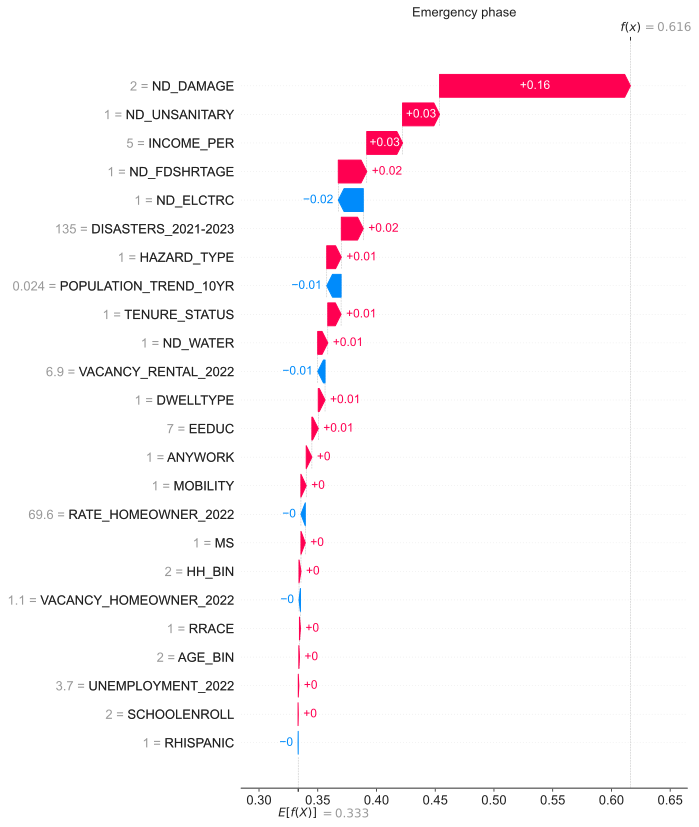

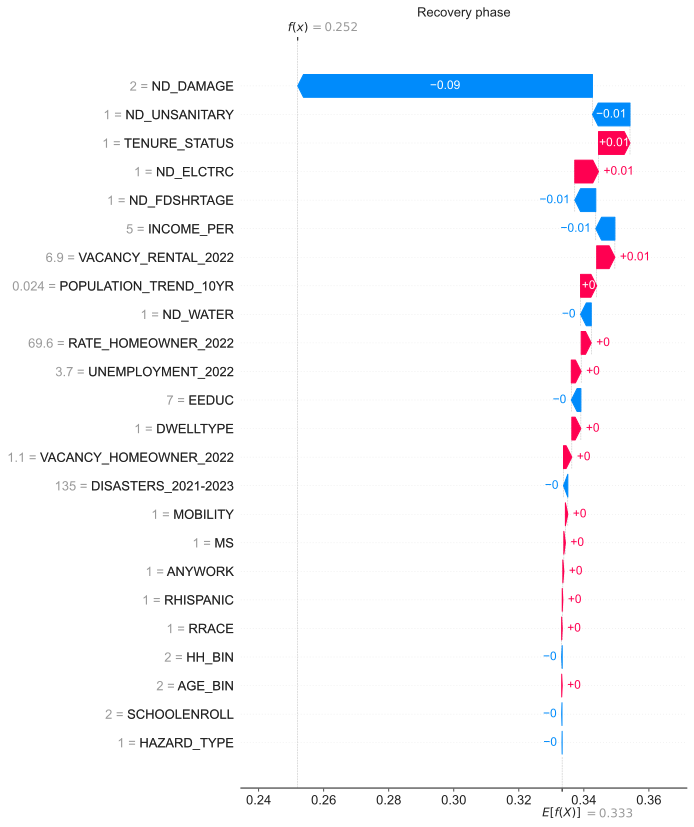

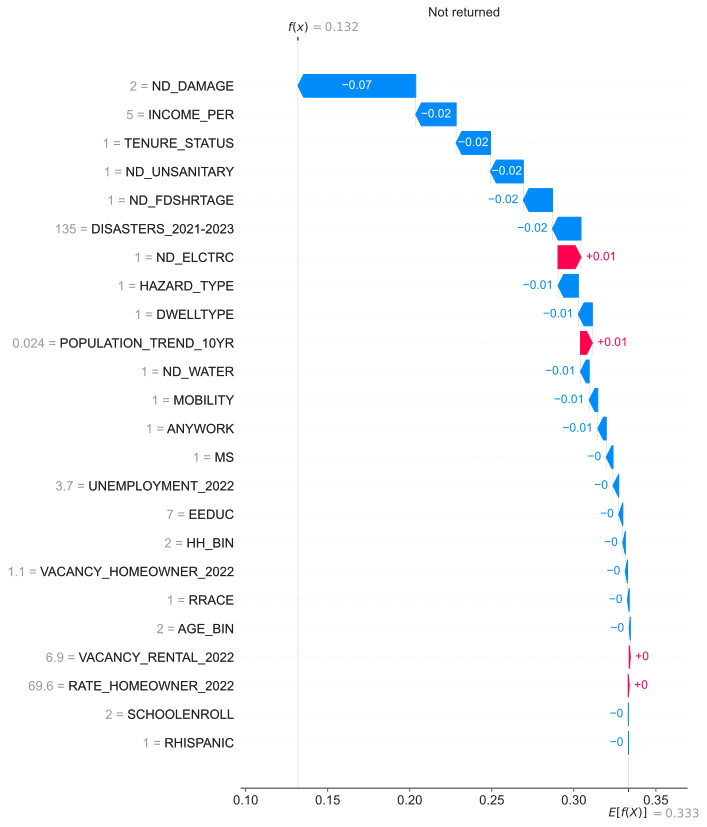

In [18]:
# visualize the first prediction's explanation
sample = 202 # emergency_phase: 202, recovery_phase: 12, no_return: 34

for i in range(3):
    class_name = class_names[i]
    shap.plots.waterfall(shap_values[sample, :, i], show=False, max_display=n_independents)
    fig, ax = plt.gcf(), plt.gca()
    ax.set_title(class_name, fontsize='x-large')
    # fig.set_size_inches(8,5)
    # fig.tight_layout()
    plt.show()

In [19]:
y.iloc[sample]

0.0

In [20]:
X.iloc[sample]

ND_DAMAGE                      2.0
ND_WATER                       1.0
ND_ELCTRC                      1.0
ND_UNSANITARY                  1.0
ND_FDSHRTAGE                   1.0
TENURE_STATUS                  1.0
HH_BIN                         2.0
SCHOOLENROLL                   2.0
INCOME_PER                     5.0
RRACE                            1
DWELLTYPE                      1.0
HAZARD_TYPE                    1.0
UNEMPLOYMENT_2022              3.7
DISASTERS_2021-2023          135.0
RATE_HOMEOWNER_2022           69.6
VACANCY_HOMEOWNER_2022         1.1
VACANCY_RENTAL_2022            6.9
POPULATION_TREND_10YR     0.023574
MS                             1.0
RHISPANIC                        1
ANYWORK                        1.0
AGE_BIN                          2
EEDUC                            7
MOBILITY                       1.0
Name: 26832, dtype: object